# Изучение архитектуры на основе U-Net в PyTorch
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1BKkyFDzl-qOLvYTV_DD3LTt-mfy9FxWt#scrollTo=9ic0H8b8qO5z) -->

В предыдущих практиках по работе с `PyTorch` мы рассмотрели задачу классификации. Однако, это не едиственная задача, которую можно решать нейронными сетями. В данном примере рассмотрим задачу семантической сегментации.  

В задачах семантической сегметнации требуется выделение каких-либо объектов в выходных данных (например, изображении) из входных данных (например, входного изображения). Как правило, такие задачи решаются формированием карт признаков конечного размера (например, совпадающего с размером исходного изображения) и имеющих число каналов, соотвествующее числу классов. Затем по всем картам признаков проводится попиксельная классификация. 

## Импорт torch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [3]:
сolab_requirements = ["pip install albumentations","pip install segmentation_models_pytorch"]

import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in сolab_requirements:
        run_subprocess_command(i)

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

import albumentations 
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [5]:
import urllib
if not os.path.exists('torch_trainer.py' ):
    url = "https://github.com/MVRonkin//Computer-Vision-Course_lec-practice/raw/refs/heads/main/2025//WS/torch_trainer.py"
    filename, headers = urllib.request.urlretrieve(url,filename='torch_trainer.py' )

In [6]:
from torch_trainer import *

In [7]:
device = setup_experiment()

[✓] Device: cuda | Seed: 42 | TF32: True


# Архитектура UNet и ее модификации

## Набор данных для сегментации

Перед тем как описать архитектуру загрузим набор данных. В этом примере мы будем использовать набор данных [`The Oxford-IIIT Pet Dataset`](https://www.robots.ox.ac.uk/~vgg/data/pets/), который может быть найден на [по официальной ссылке](https://www.robots.ox.ac.uk/~vgg/data/pets/). Набор данных содержит изображения кошек и собак, которые требуется сегментировать и аннотацию к каждому изорбажению.

Аннотация в данном случае подразумевает маску, по которой должен быть сегментирован объект на изображении. Все аннотации имеют размер, соответствующий изображению. Каждая маска может принимать одно из трех значений:
* 1 - пиксель пренадлежит классу петомец;
* 2 - пиксель пренадлежит классу фон;
* 3 - пиксель пренадлежит классу граница.
Однако, в данном примере мы будем рассматривать только 1 и 2-й классы. 

Отметим, что задача распознования границ объектов представляет отдельный класс задач семантической сегментации, подразумевающий специфичный вид функции потерь. 

Попробуем загрузить набор данных. В данном случа набор будет представлен двумя архивами, один с изображениями, и второй с их анннотацией. Отметим, что данный урок вдохнавлен [этим примером](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/).

Также отметим, что на самом деле набор данных входит в модуль `torchvision.datasetes`. Для вызова из набора можно воспользоваться следующим кодом.
```
trainvaldata = torchvision.datasets.OxfordIIITPet(root  = './data',
                                                  split = 'trainval', 
                                                  target_types = 'segmentation',
                                                  download  = True, 
                                                  transform = train_transforms)


testdata = torchvision.datasets.OxfordIIITPet(root = './data', 
                                             split = 'test', 
                                             target_types = 'segmentation',
                                             download  = True, 
                                             transform = test_transforms)
```                                             

In [8]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [9]:
url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
root_directory = os.path.join(os.getcwd(),'data','pets')

archive_name = url_images.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_images, root_directory)


url_anno   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

archive_name = url_anno.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_anno, root_directory)

Посмотрим содержания созданного архива. Архив содержит директорию изображениями `images` и директорию с аннотацией `images/trimaps`. Всего в архиве должно быть 7393 изображения. 

In [10]:
content = os.listdir(root_directory)
print(content)
print('n images = ',len(os.listdir(os.path.join(root_directory, 'images'))))
# print('n anno = ',len(os.listdir(os.path.join(dataset_directory, content[0], "trimaps" ))))

['annotations', 'annotations.tar.gz', 'images', 'images.tar.gz']
n images =  7393


Теперь пробуем разбить изображения на тренировочную, валидационную и тестовую выборки. 

В тренировочную выборку поместим 6000 случайно выбранных изображений.
В тестовую выборку поместим 100 случайно выбранных изображений.

In [11]:
N_TRAIN = 6000
N_TEST  = 100
STEP    = 5

images_directory = os.path.join(root_directory, "images")
masks_directory  = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = os.listdir(images_directory)

images_filenames = [i for i in images_filenames 
                        if os.path.splitext(i)[-1]                     
                            in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]

os.path.splitext('/path/to/somefile.ext')

random.shuffle(images_filenames)

train_images_filenames = images_filenames[:N_TRAIN:STEP]
val_images_filenames   = images_filenames[N_TRAIN:-N_TEST:STEP]
test_images_filenames  = images_filenames[-N_TEST::STEP]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1200 258 20


Для загрузки наборов данных создаим свой загрузчик. Данная тема уже поднималась в рамках урока по основам работы с данными в `PyTorch`. Напомним, что  свой набор данных при помощи  класса наследника `Dataset`.
Загрузчик данных должен иметь следующий вид.
```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
Подробную информацию можно найти в документации [тут](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) и в официальном примере [тут](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

В нашем случае мы создадим загрузчик данных `PetsDataset`. Загрузчик буде позволять работать с заданным списком изображений, указанным в `images_filenames`. Изображения будут браться из директории `images_directory`, а маски из директории `masks_directory`. Для изображений будут доступны преобразования `transforms`. В рамках класса загрузчика функция `__getitem__` является основной. Она должна получать на входе номер элмента и выдавать для номера входные и выходные данные. Также класс будет содержать функцию `preprocess_mask`, цель которой в том, чтобы убрать ненужный класс рамок изображений. 

В этом уроке мы будем использовать сторонюю библиотеку для аугментации данных. Библиотека [`albumentation`](https://albumentations.ai/docs) является одним из наиболее популярных инструментов аугментации в задачах компьютерного зрения. Примеры использования данной бибилотеки для решения задач семантической сегментации могут быть найдены в официальной документации [тут](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/) и [тут](https://albumentations.ai/docs/examples/example_kaggle_salt/). Ипользование данной библиотеки подразумевает особый тип загрузки данных в `PyTorch`. В данном случае это сводится к модификации метода `__getitem__` и добавлении туда следующих строк кода:
```python
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]
```

In [12]:
class PetsDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transforms=None):
        
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory  = masks_directory
        
        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)
   
    def preprocess_mask(self, mask):
        mask = np.asarray(mask).astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask
    
    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]
        
        path_ = os.path.join(self.images_directory, image_filename)    
        image = np.asarray(Image.open(path_).convert("RGB"))
        
        path_ = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png"))    
        mask  = Image.open(path_)
        mask  = self.preprocess_mask(mask)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]

        return image, mask.long()

In [13]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = A.Compose([A.Resize(280, 280),   
                             A.RandomCrop(256,256),
                             A.ShiftScaleRotate(0.2,0.2, 30),
                             A.RGBShift(25,25,25),
                             A.RandomBrightnessContrast(0.3,0.3),
                             A.Normalize(mean, std),
                             ToTensorV2(),])

test_transform = A.Compose([A.Resize(256, 256), 
                            A.Normalize(mean, std), 
                            ToTensorV2()])

train_dataset = PetsDataset(train_images_filenames, images_directory, masks_directory, transforms=train_transform,)

val_dataset   = PetsDataset(val_images_filenames,   images_directory, masks_directory, transforms=test_transform,)

test_dataset  = PetsDataset(test_images_filenames,  images_directory, masks_directory, transforms=test_transform,)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1200
Valid size: 258
Test size: 20


C:\Users\Ronkin\anaconda3\envs\py39\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Теперь попробуем визуализировать некоторые изображения и их маски. Для этого создадим функцию visualize_data

In [14]:
from PIL import Image
def visualize_dataset(dataset, samples=5, predicted_masks = None, mean = mean, std = std):
    dataset = copy.deepcopy(dataset)
    cols = 3 if predicted_masks else 2
    
    figure, ax = plt.subplots(nrows=samples, ncols=cols, figsize=(10, 12))
    
    for i in range(samples):
        image, mask = dataset[i]
        
        image = image.data.cpu().numpy().transpose((1,2,0))
        image = np.clip(image*std + mean,0,1)
        
        mask = np.clip(mask,0,1)
               

        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Image"); ax[i, 0].set_axis_off()
        ax[i, 1].imshow(mask.data.cpu().numpy(), interpolation="nearest")
        ax[i, 1].set_title("Ground Truth");  ax[i, 1].set_axis_off()     
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted Mask"); ax[i, 2].set_axis_off()
    
    plt.tight_layout()
    plt.show()

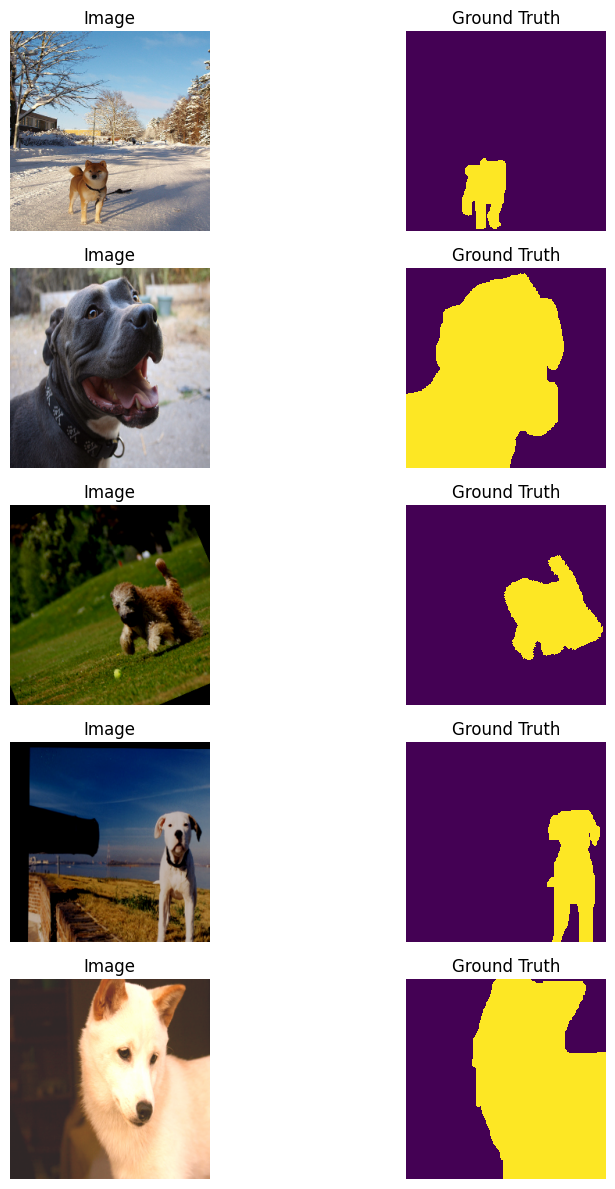

In [15]:
visualize_dataset(train_dataset, samples=5)

In [16]:
BATCH = 4

train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH,
                shuffle=True)

val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH,
                shuffle=False)

test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH,
                shuffle=False)

## Архитектура UNet



В данном уроке мы будем будем решать задачу сематической сегментации  на основе архитектуры `U-Net`. Данная архитектура состоит из двух частей: энкодера и декодера. Обе части имеют следующее назначение.
* __Энкодер__ (кодировщик, encoder) сжимает исходные данные в т.н. "набор карт латентных признаков". То есть выделить и "закодировать" признаки в заданное, достаточно большое, число карт признаков небольшого размера. Однако, особенностью энкодера является выделение и сохранение карт признаков на разных этапах сжатия.
* __Декодер__ (decoder) занимается раскодированием признаков в карыт выхондого размера. Однако, в архитектурах `U-Net`, такое раскодирование происходит с использованием информации, сохраненной энкодером на каждом из соответствующих этапов. Это достигается за счет соединения слоев, получаемых в декодере непосредственно и аналогичных по размеру слоев энкодера.

Отметим, что архитектура `U-Net` была предложенна в 2015 для решения ряда медицинских задач, офицальная статья может быть найдена по ссылке [тут](https://arxiv.org/abs/1505.04597). На данный момент семейство архитектур на базе `U-Net` является одним из наиболее популярных для решения задач семантической сегментации.

Схема данной сети показана на рисунке ниже.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png" width="500px">


> Отметим, что на официальном сайте `PyTorch` может быть найден пример работы с `U-Net` при помощи `torch.hub` ([тут](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)). А также, порекомендуем сторонюю библиотеку для работы с моделями семантической сетментации [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch). 

Теперь опишим стандартную архитектуру `U-Net`. В данном случае мы будем описывать архитектуры "с нуля".

Отметим, что при необходимости также можно ознакомится с [этим](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py) примером. 

В основе архитектуры будет лежать блок заданного типа. В нашем случае это упрощенный блок `U-Net`. Блок состоит из двух сверток, сохраняющих размерность карт признаков. Число каналов сверток может управляться.

In [17]:
def conv_block(in_channels, out_channels, mid_channels = None):
    if mid_channels is None:
        mid_channels = out_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels,  mid_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),        
        nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True))   

Теперь составим из блоков архитектуру.  
* Архитектура будет состоять из 4 ступеней.
* Каждая стуепнь энкодера сжимает размер карт аризнака в два раза и увеличивает число карт признаков в степень 2.
* Выход каждой ступени необходимо сохранить, так как он будет использоваться в декодере.
* Каждая ступень декодера повышает разменость входящей карты признаков.
* Затем к картам признаков декодера добавляются признаки энкодера как новые каналы. То есть методом конкатенации.
* Полученный набор карт признаков проходит через сверточный блок.

In [18]:
SIZE = 32
class UNet(nn.Module):

    def __init__(self, n_channels = 1, n_class=1):
        super().__init__()
                
        self.down1 = conv_block(n_channels, SIZE)
        self.down2 = conv_block(SIZE,       SIZE*2)
        self.down3 = conv_block(SIZE*2,     SIZE*4)
        self.down4 = conv_block(SIZE*4,     SIZE*8)        

        self.maxpool  = nn.MaxPool2d(2)
        
        self.upsample = nn.Upsample(scale_factor=2, 
                                    mode='bilinear', 
                                    align_corners=True)
        
        
        self.up3 = conv_block(SIZE*4 + SIZE*8, SIZE*4)
        self.up2 = conv_block(SIZE*2 + SIZE*4, SIZE*2)
        self.up1 = conv_block(SIZE*2 + SIZE,   SIZE)
        
        self.out = nn.Conv2d(SIZE, n_class, 3, padding=1)
      
    #---------------------------------------------    
    def forward(self, x):
        
        #ENCODER
        conv1 = self.down1(x)
        x = self.maxpool(conv1)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down3(x)
        x = self.maxpool(conv3)   
        
        x = self.down4(x)
        
        #DECODER
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.up1(x)
        
        out = self.out(x)
        
        return out

In [19]:
model = UNet(n_channels=3, n_class=1)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 256, 256]          --
├─Sequential: 1-1                        [1, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 256, 256]         64
│    └─ReLU: 2-3                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 32, 256, 256]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 256, 256]         64
│    └─ReLU: 2-6                         [1, 32, 256, 256]         --
├─MaxPool2d: 1-2                         [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 64, 128, 128]         18,432
│    └─BatchNorm2d: 2-8                  [1, 64, 128, 128]         128
│    └─ReLU: 2-9                         [1, 64, 128, 128]         --
│    └

## Функции потерь и метрики семантической сегментации

Для моделей семантической сегментации, как правило используется функция потерь, представляющая комбинацию кросс-энтропии и т.н. расстояния  `Dice`. Последние соотвествует 1 - т.н Коэффициент Серенса-Дайса (или `Dice`).

Метрика `Dice` представляет отношение удвоенной площади пересечения искомого объекта (макси) к сумме площадей искомого объекта и полученного по результатам работы нейронной сети. Расстояние, соответствующиее коэффициенту `Dice` расчитчвается как:

$$dice = 1 - \frac {2\cdot(A\cap B)}{|A|+|B|}$$

где $A,B$ - это площади полученного и искомого объектов, знак $\cap$ - это обозначение пересечения площадей.

Создадим дайс функцию потерь `dice_loss` и класс функуции потерь `DiceBCELoss`. Данный класс соответствует библиотеке `Loss Function Library`, которая может быть найдена по ссылке [тут](https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook) и [тут](https://github.com/JunMa11/SegLoss/tree/master/losses_pytorch).

> Обратите внимание, что `Dice`  ожидает на входе по сути вероятности. Поэтому на результат работы нейронной сети накладывается сигмоид.

Для конечной функции потерь будем использовать комибнацию `Dice` и бинарной кросс энтропии (`BCE`), оба значения как правило суммируются с некоторыми весами.  Это связно с тем, что значения `BCE` более чувствительны к таким вещам, как небольшие изменения формы объекта, тогда как `Dice` более чувствителен к геометрическому расположению сегментируемой области.

Таким образом в функции потерь будет учитываться место объекта и его площадь (`Dice`), а также особенности формы объекта с точки зрения его параметров, например яркости или особенностей формы (например широховатости краев) (`BCE`).

In [20]:
def dice_loss(pred, target, smooth=1):
    #flatten label and prediction tensors
    
    pred    = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()                            
    loss = 1 - (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)  
    
    return loss

class DiceBCELoss(nn.Module):
    def __init__(self, weight=1):
        super().__init__()
        self.weight = weight

    def forward(self, pred, target, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        pred = torch.sigmoid(pred)       
        
        dice = dice_loss(pred, target, smooth=1)
        
        bce = F.binary_cross_entropy(pred.squeeze(), target.squeeze(), reduction='mean')
        dice_bce = self.weight*bce + dice*(1-self.weight)
        
        return dice_bce

Метрика для оценки результатов работы также будет `Dice`. То есть мы хотим понять на сколько точно соотвествует позиция и размер сегентируемой области и маски.

In [21]:
def accuracy(y_pred, y):
    return 1-dice_loss(torch.sigmoid(y_pred), y, smooth=1)

## Обучение архитектуры

In [22]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.AdamW(trainable_parameters, lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3)
criterion=torch.nn.CrossEntropyLoss().to(device)
model.to(device);

In [23]:
history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler = scheduler,
    criterion=criterion,
    metrics={'accuracy':accuracy},
    device=device,
    epochs=30,
    patience=7,
    monitor_metric="accuracy",
    mode="max",
    use_amp=(device.type == "cuda"),
    ema_decay=0.999,
    grad_clip=1.0,
    accumulation_steps=1,
    checkpoint_path="best_model.pt",
)

Train:   0%|          | 0/300 [00:00<?, ?it/s]

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Проведем инициализацию модели

In [ ]:
def init_weights(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear): 
        nn.init.xavier_uniform_(m.weight)

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)
            
model.apply(init_weights);

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                train_loader, 
                                                optimizer, 
                                                criterion,
                                                accuracy, 
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   val_loader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')



In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Посмотрим на результат работы сети. Обратите внимание, что для результата берется функция активации ( в данном случае `sigmoid`).

In [ ]:
x,y = next(iter(val_loader))

x = x.to(device)
y = y.to(device)

y_pred = torch.sigmoid(model.forward(x))
y_pred.shape

In [ ]:
id = 1
plt.imshow(y_pred[id,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[id,:,:].detach().cpu().numpy()); plt.show()

Отметим, что чаще всего предсказания должно быть бинаризированно по некоторому пороговому значению. Это значение можно интерпретировать как порог уверенности (вероятности) с которой мы готовы признать некоторый пиксель принадлежащим объекту или нет.

In [ ]:
threshold = 0.3
y_pred[y_pred>=threshold]=1
y_pred[y_pred<threshold]=0
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()

## Задания

__1.__ Особенностью  `UNet` является наличие связей между картами признаков энкодера и декодера на разных этапах. Это позволяет улавливать мелко-размерные объекты и особенности сегментируемых участков. Однако, с точки зрения вычислительных рессурсов это допо лнительные сложности. Поэтому ряд архитектур, таких как SegNet не используют карты признаков.
__Предлагается__ преобразовать архитектуру `UNet` в `SegNet`, сравните результаты.

__2.__ Ранее рассматривались различные приемы улучшения архитектур нейронных сетей, например использование глубокой разделенной свертки или блока ConvNext. __Предлагается__ проверить качество работы архитектуры при указанных изменениях.

__4.__ Ниже приведена более классическая реализация архитектуры `UNet`.  Такие рализации можно найтит например [тут](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py) или [тут](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py) Сравните результат работы такой модели с полученной.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits    

__5.__ В современном подходе дифузоинные нейронные сети архитектура типа UNet используется в качестве архитектуры для решения задачи `denoising`. Это задача без учителя типа автоэнкодер. В задаче на вход подается зашумленное изображение, выход должен быть освобожден от шумов. Как мнимум это можно сделать сравнить вход до зашумления с выходом при помощи регрессионной функции потерь. __Предлагаем__ реализовать такую архитекутру.

__6.__ Одной из наиболее популярных библиотек для решения задач сегментации при помощи сверточных нейронных сетей является  [`segmentation_models_pytorch`, `SMP`](https://github.com/qubvel/segmentation_models.pytorch). Библиотек `SMP` предоставляет широкий перечень архитектур сегментации и кодировщиков для них. Такими кодировщиками могут быть как встроенные модели, например resnet и efficientnet так и набор кодировщиков `timm`. Также `SMP`предоставляет ряд вспомогательных функций. Более подробную информацию можно найти в  [официальной документации](https://segmentation-modelspytorch.readthedocs.io/en/latest/) и [уроках](https://github.com/qubvel/segmentation_models.pytorch/tree/master/examples).  Ниже приведен пример использования библиотек

In [ ]:
!pip install segmentation_models_pytorch -q -U

In [ ]:

import segmentation_models_pytorch as smp
# We will use Feature Pyramid Network with pre-trained efficientnet backbone
model = smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1,)


также, на самом деле, можно работать и с функциями потерь.
```python
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
criterion.to(device)
```
см.  [тут](https://smp.readthedocs.io/en/latest/losses.html).

In [ ]:
LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                train_loader, 
                                                optimizer, 
                                                criterion,
                                                accuracy, 
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   val_loader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

In [ ]:
x,y = next(iter(val_loader))
x = x.to(device)
y = y.to(device)
y_pred = torch.sigmoid(model.forward(x))
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

**Предлагаем**  сравнить несколько моделей из SMP [можно найти тут](https://github.com/qubvel/segmentation_models.pytorch#models) с несколькими энкодерами [можно найти тут](https://github.com/qubvel/segmentation_models.pytorch#encoders).

__7.__ Пакет `SMP` cодержит функцию потерь `FocalLoss`, позволяющую решать задачи с дисбалансом классов. Такой дисбаланс возникает в силу неравномерности различных локальных областей сегментации и фона на изображениях. __Предлагаем__ реализовать обучение с использованием `FocalLoss`.